In [536]:
import pandas as pd
from pandas import read_csv 
import numpy as np
import datetime
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import collections

In [537]:
dataset=read_csv('soc-sign-bitcoinotc.csv',header=None, names=["source", "target", "rating","time"])

In [538]:
print(dataset.head(5))
print(dataset.shape)

   source  target  rating          time
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
(35592, 4)


In [539]:
# arrtime=[]
# for a in dataset.iloc[:,-1]:
#     arrtime.append(datetime.datetime.fromtimestamp(a))

In [540]:
# dataset.drop('time', inplace=True, axis=1)    
# dataset.insert(3, "time", arrtime, True)
# print(dataset.head(5))

In [541]:
dataset.loc[pd.DataFrame(np.sort(dataset[['source','target']],1),index=dataset.index).drop_duplicates(keep='first').index]
dataset.head(5)

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [542]:
dataset['time'] = pd.to_datetime(dataset.time * 1e9)
dataset = dataset.set_index('time')
dataset.shape

(35592, 3)

In [543]:
dataset.tail(5)

,source,target,rating
time,,,
2016-01-24 05:14:41.647290112,4499,1810,1
2016-01-24 23:50:28.049489920,2731,3901,5
2016-01-24 23:50:34.034019840,2731,4897,5
2016-01-24 23:53:52.985709824,13,1128,1
2016-01-25 01:12:03.757280000,1128,13,2


In [544]:
# ratings overview by month
dataset.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2015-08-31,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,34.0,19.0,8.0,1.0,1.0,2.0,5.0,1.0,NaN,NaN
2013-05-31,45.0,2.0,1.0,NaN,1.0,5.0,NaN,1.0,1.0,20.0,674.0,166.0,63.0,31.0,48.0,7.0,3.0,10.0,5.0,34.0
2013-06-30,43.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,11.0,609.0,140.0,53.0,30.0,35.0,15.0,5.0,7.0,NaN,16.0
2014-03-31,36.0,NaN,2.0,NaN,NaN,7.0,1.0,1.0,7.0,13.0,157.0,37.0,21.0,17.0,12.0,3.0,2.0,1.0,5.0,8.0
2014-10-31,3.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,3.0,10.0,120.0,40.0,12.0,11.0,17.0,3.0,2.0,3.0,NaN,2.0


In [545]:
tp1 = dataset.loc['2014']
print(f"Ratings: {len(tp1)}")
tp1.sample(10)

Ratings: 4225


,source,target,rating
time,,,
2014-03-27 08:14:30.047069952,4559,115,2
2014-10-29 04:17:40.795439872,5525,5482,1
2014-07-23 19:51:08.656349952,540,4197,3
2014-02-19 22:37:39.895430144,905,4611,1
2014-04-15 02:57:19.832960000,5501,2296,1
2014-02-11 21:19:53.263889920,2125,5389,-1
2014-05-31 03:36:33.623040000,361,5472,-1
2014-09-25 16:21:21.371150080,5800,5712,1
2014-03-20 22:13:41.616229888,2125,5467,-2


In [546]:
G = nx.Graph()
for i in tp1.index:
  G.add_edge(dataset['source'][i], dataset['target'][i], weight = dataset['rating'][i])

In [547]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 1145\nNumber of edges: 2873\nAverage degree:   5.0183'

In [548]:
# nx.draw(G)  
# plt.draw()
nx.is_connected(G)

False

target
1       27
2        3
3        3
6        7
7        3
        ..
5873     2
5874     2
5875     2
5876     1
5877     1
Name: rating, Length: 1098, dtype: int64
target
1        3.925926
2        1.333333
3       -9.000000
6       -2.857143
7        1.333333
          ...    
5873   -10.000000
5874   -10.000000
5875   -10.000000
5876     2.000000
5877     1.000000
Name: rating, Length: 1098, dtype: float64


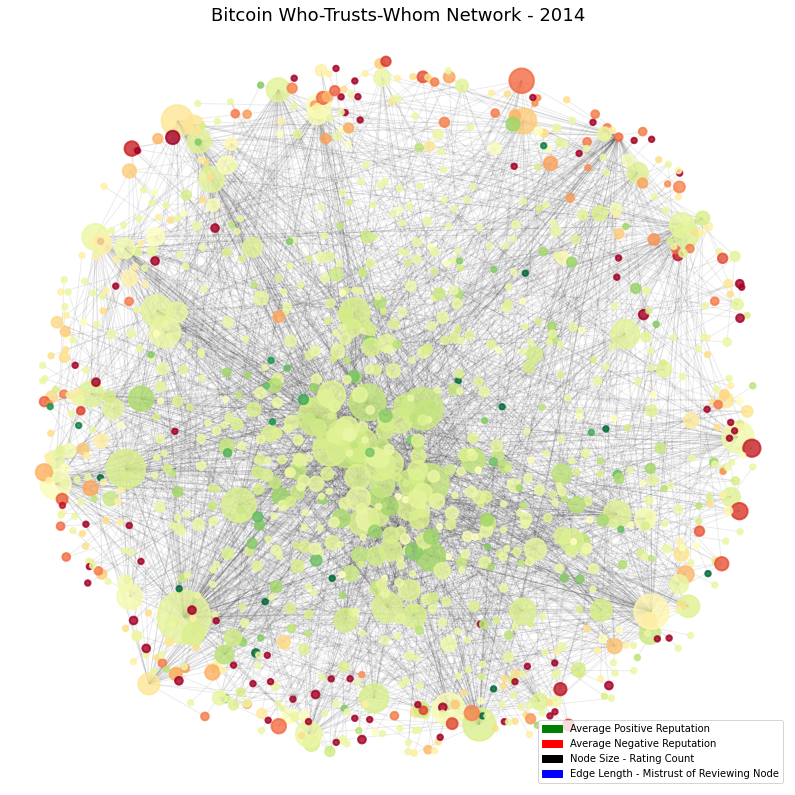

In [549]:
review_counts = tp1.groupby('target').rating.count()
average_reviews = tp1.groupby('target').rating.mean()
print(review_counts)
print(average_reviews)
def get_size(user_id, m=20, min=30):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network - 2014", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='black', label='Node Size - Rating Count')
edges = mpatches.Patch(color='blue', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(G, k=0.25)
sizes = [get_size(n) for n in G]
colors = [get_color(n) for n in G]

nc = nx.draw_networkx_nodes(
    G, pos, nodelist=G.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.08)
ax = plt.axis('off')
plt.show()

[Text(0, 0, '171'),
 Text(0, 0, '107'),
 Text(0, 0, '94'),
 Text(0, 0, '91'),
 Text(0, 0, '88'),
 Text(0, 0, '73'),
 Text(0, 0, '64'),
 Text(0, 0, '62'),
 Text(0, 0, '54'),
 Text(0, 0, '53'),
 Text(0, 0, '52'),
 Text(0, 0, '48'),
 Text(0, 0, '46'),
 Text(0, 0, '44'),
 Text(0, 0, '43'),
 Text(0, 0, '42'),
 Text(0, 0, '41'),
 Text(0, 0, '40'),
 Text(0, 0, '38'),
 Text(0, 0, '37'),
 Text(0, 0, '36'),
 Text(0, 0, '35'),
 Text(0, 0, '34'),
 Text(0, 0, '33'),
 Text(0, 0, '32'),
 Text(0, 0, '31'),
 Text(0, 0, '30'),
 Text(0, 0, '29'),
 Text(0, 0, '28'),
 Text(0, 0, '27'),
 Text(0, 0, '26'),
 Text(0, 0, '25'),
 Text(0, 0, '24'),
 Text(0, 0, '23'),
 Text(0, 0, '22'),
 Text(0, 0, '21'),
 Text(0, 0, '20'),
 Text(0, 0, '19'),
 Text(0, 0, '18'),
 Text(0, 0, '17'),
 Text(0, 0, '16'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3')

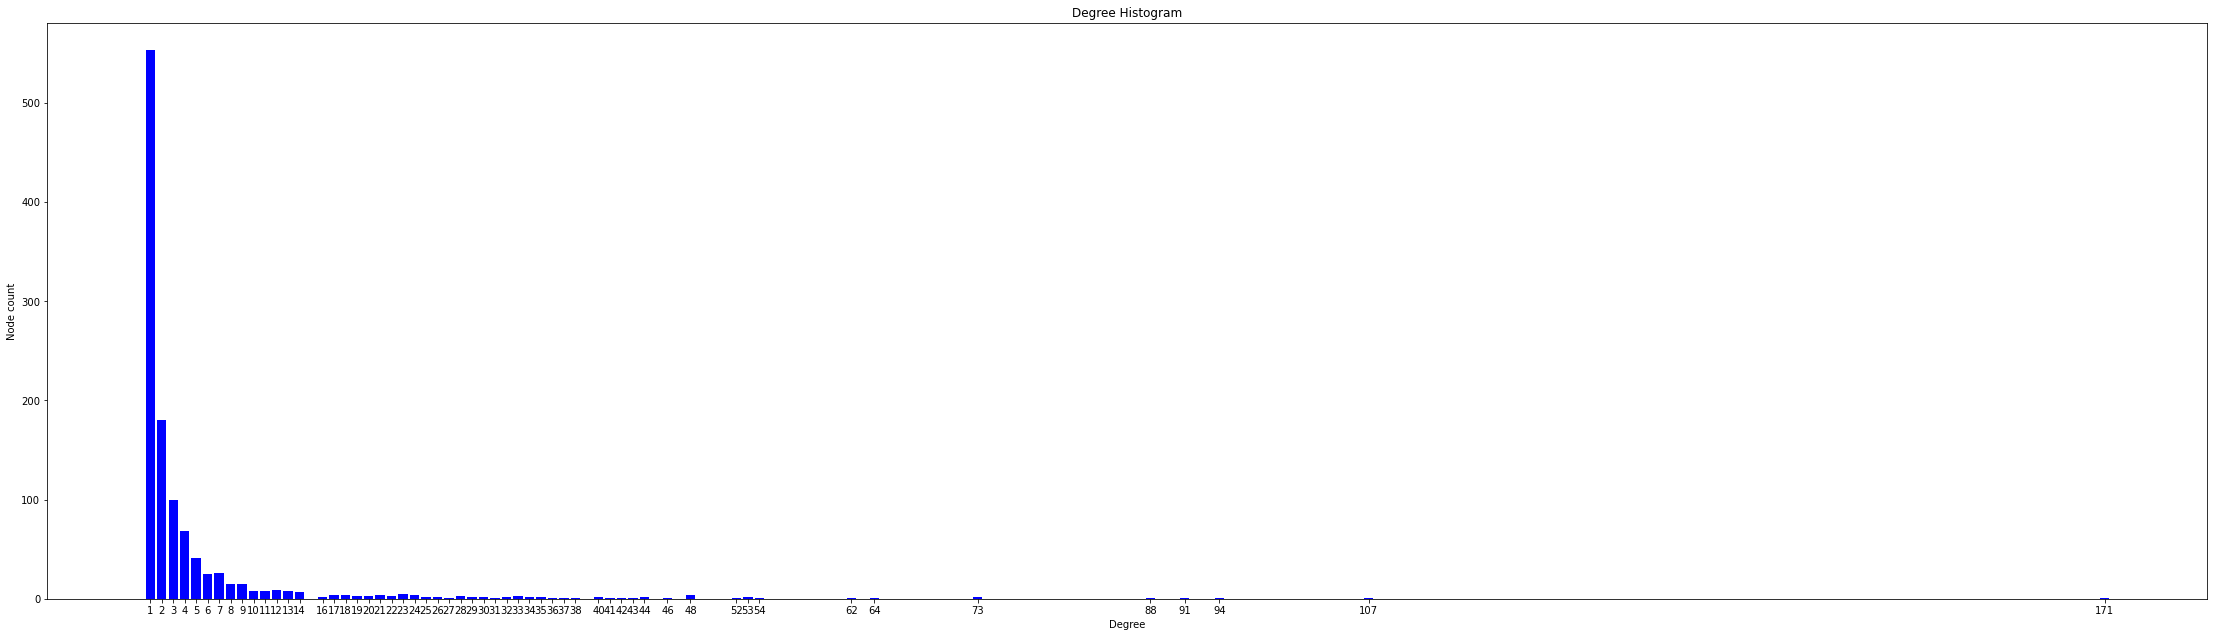

In [550]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
#plt.figure(figsize = (200, 100))
plt.subplots_adjust(left=0, right=5, bottom=0, top=2)
plt.bar(deg, cnt, width=0.8, color="b")
plt.title("Degree Histogram")
plt.ylabel("Node count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

In [ ]:
l = []
for i in dataset.index:
    if(dataset['rating'][i]<0):
        l.append(dataset['source'][i])
#print(l)  

x = nx.closeness_centrality(G)
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_x[-20:]:
    closeness.append(i[0])
#print(closeness)    
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("closeness - fraudulent nodes :" , np.unique(common))      

y = nx.degree_centrality(G)
import operator
sorted_y = sorted(y.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_y[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("degree - fraudulent nodes :" , np.unique(common)) 

z = nx.betweenness_centrality(G)
import operator
sorted_z = sorted(z.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_z[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("betweeness - fraudulent nodes :" , np.unique(common)) 

a = nx.pagerank(G,max_iter=10000)
import operator
sorted_a = sorted(a.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_a[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("pagerank - fraudulent nodes :" , np.unique(common)) 


closeness - fraudulent nodes : [   1  905 1352 1810 2045 2388 2835 3345 3722 3878 3988 4172 4291 4515
 4611 4649 5472 5508 5612]
degree - fraudulent nodes : [  35 1352 1810 2045 2125 2934 3451 3640 3707 3722 3828 3878 3897 3988
 4172 4197 4291 4385 5363 5612]
betweeness - fraudulent nodes : [   1   35 1352 1810 2045 2125 2934 3451 3707 3722 3878 3988 4172 4197
 4291 4385 4611 5363 5612]


c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: overflow encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: overflow encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: invalid value encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: invalid value encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\l

In [ ]:
# y = nx.degree_centrality(G)
# import operator
# sorted_y = sorted(y.items(), key=operator.itemgetter(1))
# print(sorted_y[-20:])

In [ ]:
# z = nx.betweenness_centrality(G)
# import operator
# sorted_z = sorted(z.items(), key=operator.itemgetter(1))
# print(sorted_z[-20:])

In [ ]:
# a = nx.pagerank(G,max_iter=10000)
# import operator
# sorted_a = sorted(a.items(), key=operator.itemgetter(1))
# print(sorted_a[-20:])

In [ ]:
# l = []
# for i in dataset.index:
#     if(dataset['rating'][i]<0):
#         l.append(dataset['source'][i])
# print(l)        


In [ ]:
# common=[]
# for i in sorted_x[-20:]:
#     for j in l:
#         if i==j:
#             common.append(j)
# print(common)            